In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
import keras

from pathlib import Path

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15, 8)

2024-12-24 12:15:54.737920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-24 12:15:54.751772: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-24 12:15:54.873302: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-24 12:15:54.996039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735013755.102700   17536 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735013755.13

In [2]:
df = pd.read_csv(
    "../data/Air Temperature Fix.csv", index_col='datetime', parse_dates=True
)
df

,airTemperature
datetime,
2024-11-01 10:21:00+00:00,26.55
2024-11-01 10:22:00+00:00,26.60
2024-11-01 10:23:00+00:00,26.60
2024-11-01 10:24:00+00:00,26.65
2024-11-01 10:25:00+00:00,26.70
...,...
2024-11-24 12:23:00+00:00,27.81
2024-11-24 12:24:00+00:00,27.80
2024-11-24 12:25:00+00:00,27.80


In [3]:
df = df.asfreq("1min")
df

,airTemperature
datetime,
2024-11-01 10:21:00+00:00,26.55
2024-11-01 10:22:00+00:00,26.60
2024-11-01 10:23:00+00:00,26.60
2024-11-01 10:24:00+00:00,26.65
2024-11-01 10:25:00+00:00,26.70
...,...
2024-11-24 12:23:00+00:00,27.81
2024-11-24 12:24:00+00:00,27.80
2024-11-24 12:25:00+00:00,27.80


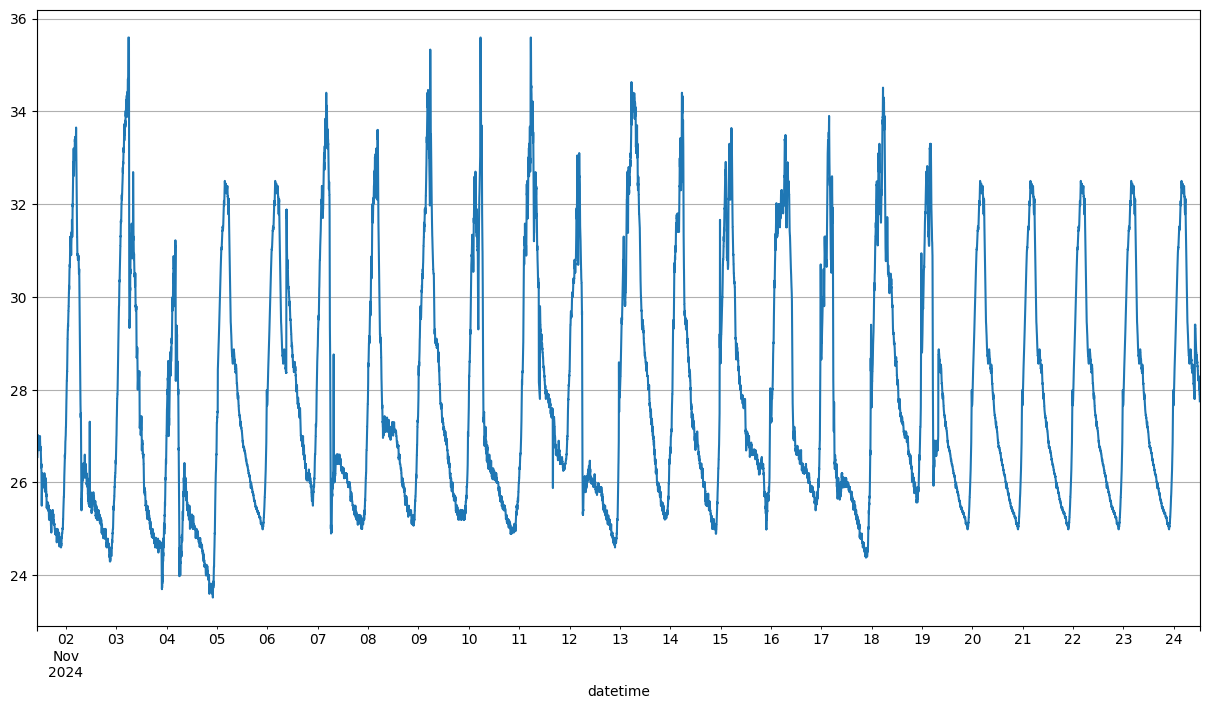

In [4]:
fig, ax = plt.subplots()
df["airTemperature"].plot(ax=ax)
plt.grid()
plt.show()

In [5]:
print(f"Number data NaN\t: {df.isna().sum()}")

Number data NaN	: airTemperature    0
dtype: int64


In [6]:
train, test = (
    df.iloc[: int(np.round(df.shape[0] * 0.7))],
    df.iloc[int(np.round(df.shape[0] * 0.7)) :],
)
train.shape, test.shape

((23273, 1), (9974, 1))

In [7]:
scaler = StandardScaler()
scaler.fit(df)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
train_scaled.shape, test.shape

((23273, 1), (9974, 1))

In [8]:
def create_features(dataset, n_past=60, n_future=1):
    X, y = list(), list()

    for i in range(n_past, len(dataset) - n_future + 1):
        X.append(dataset[i - n_past : i, 0 : dataset.shape[1]])
        y.append(dataset[i + n_future - 1 : i + n_future, 0])

    return np.array(X), np.array(y)


X_train, y_train = create_features(train_scaled)
X_test, y_test = create_features(test_scaled)

In [9]:
print(f"X_train shape\t: {X_train.shape}")
print(f"y_train shape\t: {y_train.shape}")

X_train shape	: (23213, 60, 1)
y_train shape	: (23213, 1)


In [10]:
model = keras.Sequential(name="LSTM")
model.add(keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(
    keras.layers.LSTM(
        64, activation=keras.activations.relu, return_sequences=True, name="lstm_1"
    )
)
model.add(
    keras.layers.LSTM(
        32, activation=keras.activations.relu, return_sequences=False, name="lstm_2"
    )
)
model.add(keras.layers.Dropout(0.2, name="dropout"))
model.add(keras.layers.Dense(y_train.shape[1], name="dense"))

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanAbsolutePercentageError(),
        keras.metrics.RootMeanSquaredError(),
    ],
)

2024-12-24 12:16:16.448075: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
model.summary()

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode="auto", baseline=None, restore_best_weights=False)

In [37]:
history = model.fit(
    X_train, y_train, epochs=500, batch_size=16, validation_split=0.2, verbose=1, callbacks=[earlyStopping]
)

Epoch 1/500
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.0954 - mean_absolute_error: 0.0954 - mean_absolute_percentage_error: 29.4771 - root_mean_squared_error: 0.1568 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - val_mean_absolute_percentage_error: 29.2738 - val_root_mean_squared_error: 0.0499
Epoch 2/500
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0994 - mean_absolute_error: 0.0994 - mean_absolute_percentage_error: 27.0627 - root_mean_squared_error: 0.1629 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_absolute_percentage_error: 19.8637 - val_root_mean_squared_error: 0.0333
Epoch 3/500
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0979 - mean_absolute_error: 0.0979 - mean_absolute_percentage_error: 32.2550 - root_mean_squared_error: 0.1613 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188 - val_mean_absolute_percentage_error: 13.0469 - val_root_mean_squared_error: 0.0278
Epoch 4/500
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/ste

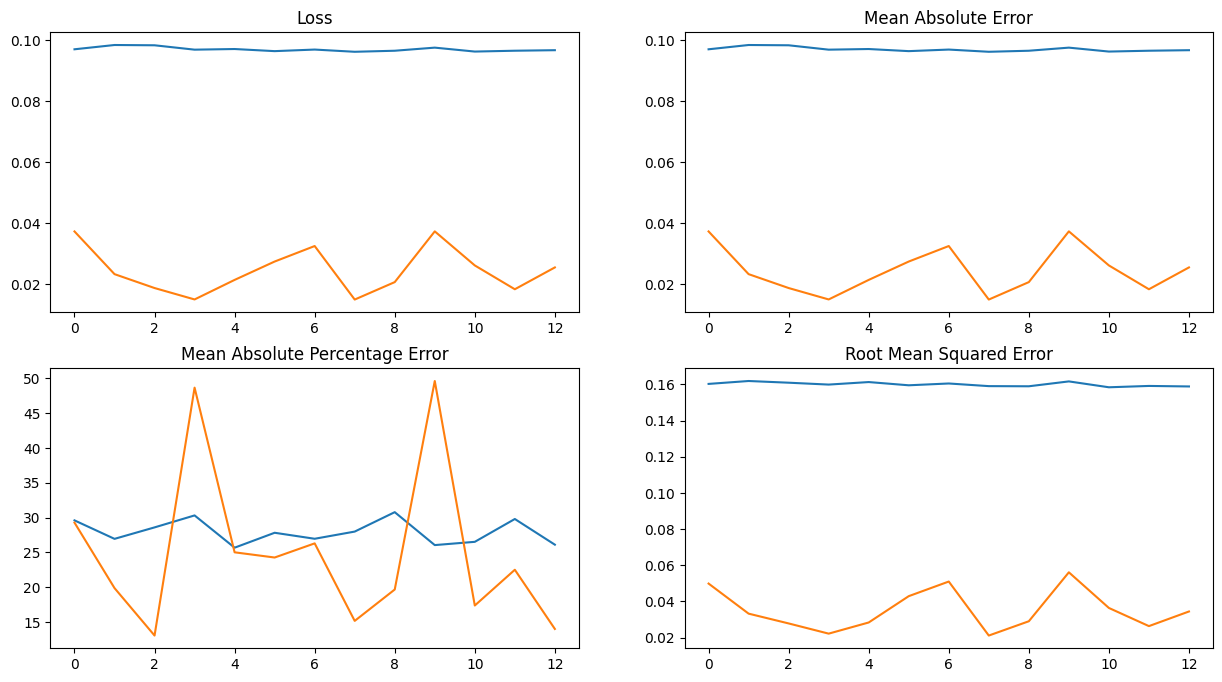

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0][0].plot(history.history['loss'])
ax[0][0].plot(history.history['val_loss'])
ax[0][0].set_title('Loss')
ax[0][1].plot(history.history['mean_absolute_error'])
ax[0][1].plot(history.history['val_mean_absolute_error'])
ax[0][1].set_title('Mean Absolute Error')
ax[1][0].plot(history.history['mean_absolute_percentage_error'])
ax[1][0].plot(history.history['val_mean_absolute_percentage_error'])
ax[1][0].set_title('Mean Absolute Percentage Error')
ax[1][1].plot(history.history['root_mean_squared_error'])
ax[1][1].plot(history.history['val_root_mean_squared_error'])
ax[1][1].set_title('Root Mean Squared Error')
plt.show()

In [39]:
model.save('./model/LSTM_airTemperature.keras')

In [40]:
loaded_model = keras.saving.load_model("./model/LSTM_airTemperature.keras")

In [41]:
pred = loaded_model.predict(X_test)
pred

310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array([[-0.85393083],
       [-0.8406625 ],
       [-0.8704796 ],
       ...,
       [-0.00705245],
       [-0.00426725],
       [-0.00374803]], dtype=float32)

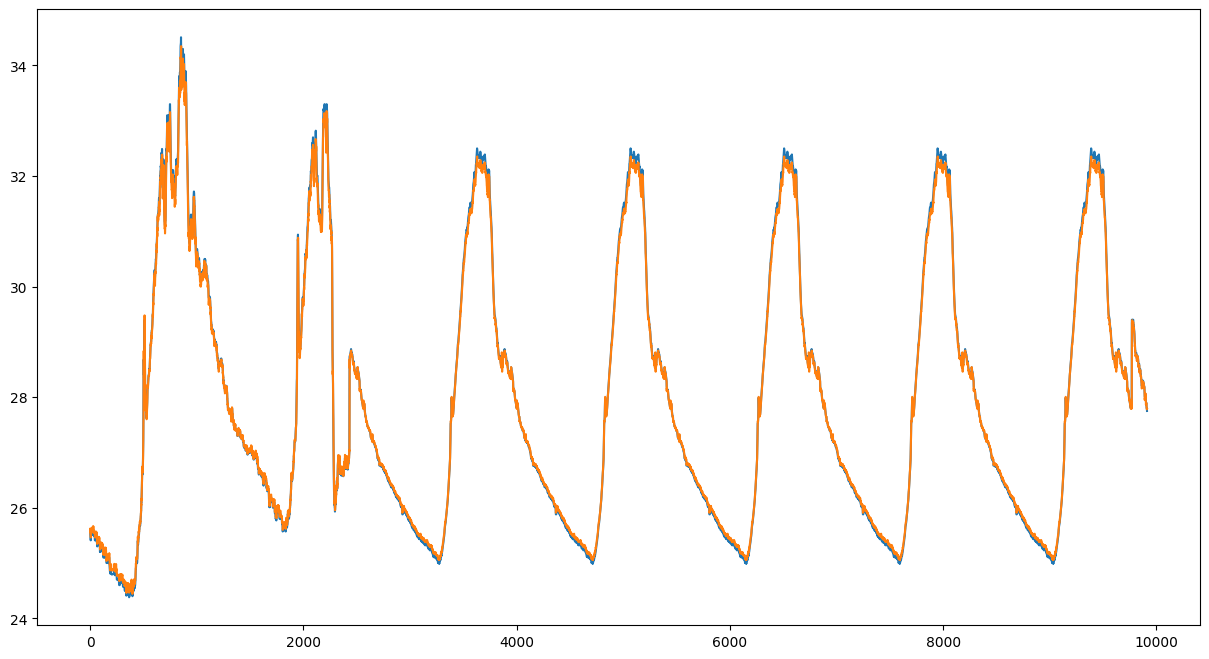

In [43]:
fig, ax = plt.subplots()
ax.plot(scaler.inverse_transform(y_test))
ax.plot(scaler.inverse_transform(pred))
plt.show()

In [44]:
mae = mean_absolute_error(scaler.inverse_transform(y_test), scaler.inverse_transform(pred))
mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test), scaler.inverse_transform(pred))
rmse = root_mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(pred))

print(f'''
mae\t: {mae}
mape\t: {mape}
rmse\t: {rmse}
''')


mae	: 0.06259329332756085
mape	: 0.002173063207204876
rmse	: 0.08358836077756945



In [67]:
future_steps = 1440
future_predictions = []
current_sequence = X_test[-1]
for _ in range(future_steps):
    next_value = loaded_model.predict(current_sequence.reshape(1, X_test.shape[1], X_test.shape[2]), verbose=0)
    future_predictions.append(scaler.inverse_transform(next_value))
    current_sequence = np.append(current_sequence[1:], next_value, axis=0)

future_predictions = np.array(future_predictions)

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)


KeyboardInterrupt: 

In [64]:
startdate = df.index[-1] + pd.Timedelta(minutes=1)
datetime = pd.date_range(start=startdate, freq='1min', periods=future_predictions.shape[0])
df_pred = pd.DataFrame({'prediction': future_predictions.reshape(-1)}, index=datetime)
df_pred

,prediction
2024-11-24 12:28:00+00:00,27.788858
2024-11-24 12:29:00+00:00,27.777000
2024-11-24 12:30:00+00:00,27.765882
2024-11-24 12:31:00+00:00,27.754797
2024-11-24 12:32:00+00:00,27.743843
...,...
2024-11-25 12:23:00+00:00,27.584927
2024-11-25 12:24:00+00:00,27.584927
2024-11-25 12:25:00+00:00,27.584927
2024-11-25 12:26:00+00:00,27.584927


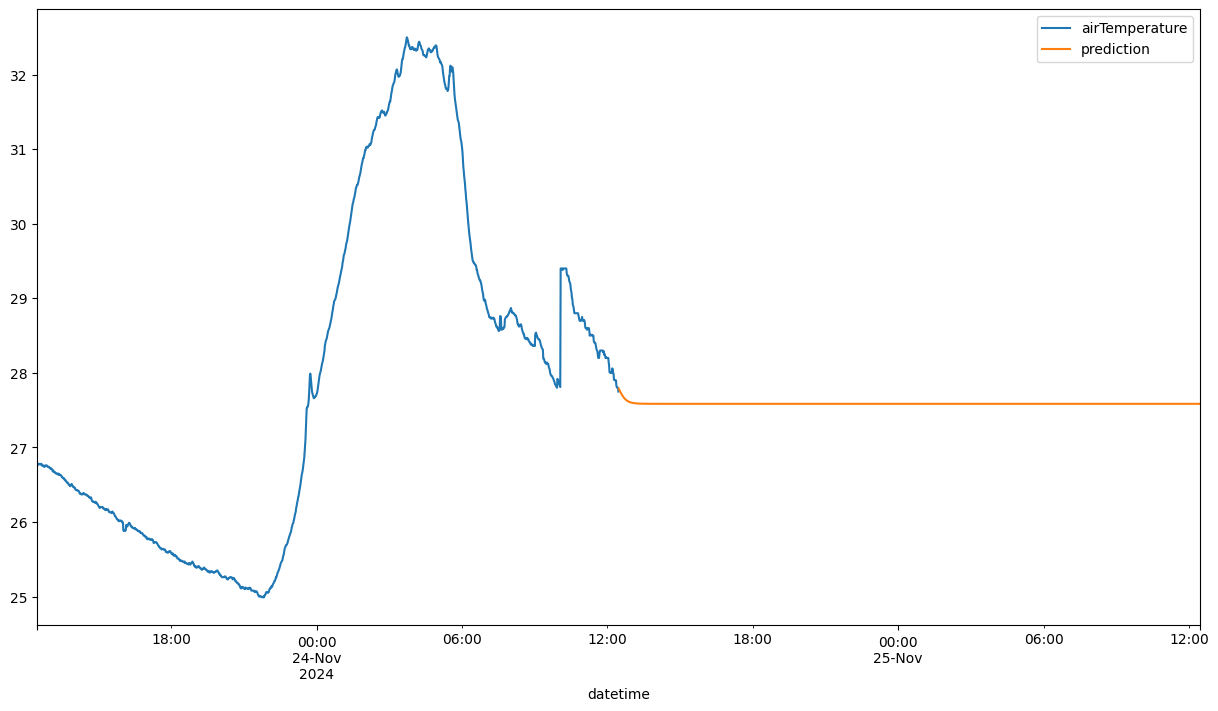

In [65]:
fig, ax = plt.subplots()
df.tail(future_steps).plot(ax=ax)
df_pred.plot(ax=ax)
plt.show()